---
title: NonLinear Shallow Water Model - Jet Example
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: NonLinear SWM (Jet)
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: tuchida@fsu.edu
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import typing as tp
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import pandas as pd
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.models.sw import Params as SWMParams, State as SWMState
from jaxsw._src.models.sw.nonlinear import ShallowWater2D

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Formulation

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ H
\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) = 0 \\
\frac{\partial u}{\partial t} &- fv =
- g \frac{\partial h}{\partial x}
- \kappa u \\
\frac{\partial v}{\partial t} &+ fu =
- g \frac{\partial h}{\partial y}
- \kappa v
\end{aligned}
$$ (eq:sw_linear)




Taking the equation from [wikipedia](https://en.wikipedia.org/wiki/Shallow_water_equations#Non-conservative_form).

**Non-Conservative Form**

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ 
\frac{\partial}{\partial x}\left((H+h)u\right) +
\frac{\partial}{\partial y}\left((H+h)v\right)= 0 \\
\frac{\partial u}{\partial t} &+ u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} - fv =
-g\frac{\partial h}{\partial x} -ku + \nu \left( \frac{\partial^2 u}{\partial x^2} + 
\frac{\partial^2 u}{\partial y^2} \right)\\
\frac{\partial v}{\partial t} &+ u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} + fu =
-g\frac{\partial h}{\partial y} -kv + 
\nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)\\
\end{aligned}
$$ (eq:sw)

| Symbol | Variable | Unit | 
|:---------:|:------|:----:|
| $u$ | Zonal Velocity |  $m/s^2$ |
| $v$ | Meridial Velocity |   $m/s^2$ |
| $H$ |Mean Height |   $m$ |
| $h$ |Height Deviation |$m$ |
|$b$ | Topographical height 


**Velocities**. The $u,v$ represent the zonal and meridional velocities in the x,y directions respectively.

**Heights** ($H,h,b$). 
The $H$ represents the mean hight of the horizontal pressure surface. 
The $h$ represents the height deviation of the horizontal pressure surface from its mean height.
$b$ represents the topographical height from a reference $D$.

$$
\begin{aligned}
\eta(x,y,t) &= H(x,y) + h(x,y,t) \\
H(x,y) &= D + b(x,y)
\end{aligned}
$$

**Constants** ($f,k,\nu$). $g$ is the acceleration due to gravity, $k$ is the viscous drag coefficient, and $\nu$ is the kinematic viscosity.

**NonLinear SW Example**

* Varying Coriolis Force
* NonLinear Terms
* Lateral Friction
* Periodic Boundary Conditions

## Domain



In [2]:
dx = dy = 5e3
Lx = 200 * dx
Ly = 104 * dy


domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy))

print(f"Nx: {domain.Nx}")
print(f"Lx: {domain.Lx}")
print(f"dx: {domain.dx}")
print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume:_}")

Nx: (201, 105)
Lx: (1000000.0, 520000.0)
dx: (5000.0, 5000.0)
Size: (201, 105)
nDims: 2
Grid Size: (201, 105, 2)
Cell Volume: 25_000_000.0


## State + Parameters

In [3]:
params = SWMParams(
    depth=100.0, gravity=9.81, coriolis_f0=2e-4, coriolis_beta=2e-11, domain=domain
)

## Initial Condition

In [4]:
def init_u0(params):
    domain = params.domain
    # grab coordinate values
    y = domain.coords[1]
    # grab grid coordinate values
    Y = domain.grid[..., 1]
    # grab number of points - y direction
    n_y = domain.Nx[1]
    # grabs physical length of domain - x direction
    l_x = domain.Lx[0]
    # makes a Gaussian Ridge?
    u0 = 10 * np.exp(-((Y - y[n_y // 2]) ** 2) / (0.02 * l_x) ** 2)

    return jnp.asarray(u0)


def init_h0(params):
    domain = params.domain
    # parse parameters and domain
    dy = domain.dx[1]
    coriolis_param = params.coriolis_param(domain)
    gravity = params.gravity
    depth = params.depth

    # grab grid coordinate values
    X, Y = domain.grid[..., 0], domain.grid[..., 1]

    # grab number of points - y direction
    n_y = domain.Nx[1]

    # grabs physical length of domain - x direction
    l_x, l_y = domain.Lx

    u0 = init_u0(params)

    # approximate balance h_y = -(f/g)u
    h0 = jnp.cumsum(-dy * u0 * coriolis_param / gravity, axis=1)

    # remove mean (make sure h0 is centered around depth)
    h0 -= h0.mean()

    # add depth
    h0 += depth

    # add small perturbation
    h0 += 0.2 * jnp.sin(X / l_x * 10 * jnp.pi) * jnp.cos(Y / l_y * 8 * jnp.pi)

    # boundaries of H must not be used!
    h0 = h0.at[0, :].set(jnp.nan)
    h0 = h0.at[-1, :].set(jnp.nan)
    h0 = h0.at[:, 0].set(jnp.nan)
    h0 = h0.at[:, -1].set(jnp.nan)

    return jnp.asarray(h0)

In [5]:
params = SWMParams(
    depth=100.0, gravity=9.81, coriolis_f0=2e-4, coriolis_beta=2e-11, domain=domain
)


h0 = init_h0(params)
u0 = init_u0(params)

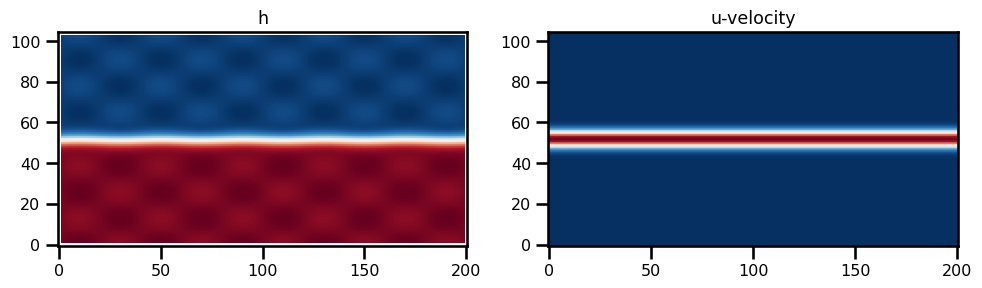

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(h0.T, origin="lower", cmap="RdBu_r")
ax[0].set(title="h")

ax[1].imshow(u0.T, origin="lower", cmap="RdBu_r")
ax[1].set(title="u-velocity")

plt.tight_layout()
plt.show()

### State Revisited

In [7]:
from jaxtyping import Array


class State(tp.NamedTuple):
    u: Array
    v: Array
    h: Array

    @classmethod
    def init_state(cls, params, init_h0, init_u0):
        h = init_h0(domain, params)
        v = jnp.zeros_like(h)
        u = init_u0(domain)
        return cls(u=u, v=v, h=h)

In [8]:
# state_init = SWMState.init_state(params, init_h=init_h0, init_u=init_u0)

# ds_results = xr.load_dataset("./sw_nonlinear_jet.nc")
# state_init = SWMState(
#     u=jnp.asarray(ds_results.u.isel(time=-1)),
#     v=jnp.asarray(ds_results.v.isel(time=-1)),
#     h=jnp.asarray(ds_results.h.isel(time=-1)),
# )

In [9]:
# fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
# ax[0].imshow(state_init.h.T, origin="lower", cmap="RdBu_r")
# ax[0].set(title="h")

# ax[1].imshow(state_init.u.T, origin="lower", cmap="RdBu_r")
# ax[1].set(title="u-velocity")

# ax[2].imshow(state_init.v.T, origin="lower", cmap="RdBu_r")
# ax[2].set(title="v-velocity")

# plt.tight_layout()
# plt.show()

## Boundary Conditions

**Period Case**:

* h, u, v - periodic in x
* v - northern boundary as zero

**NonPeriodic Case**:

* h - nothing
* u - east boundary as zero
* v - northern boundary as zero

### Height Equation

Remember [](#eq:sw) 

However, there are some tricky things that we need to do first.

* Pad the H domain to include the u-v components
* Calculate h on the u and v components respectively
* calculate the hu, hv components
* calculate the derivative of dhu_dx and dhv_dy

### U-Velocity

Remember [](#eq:sw) 

**Note**: written in *vector invariant momentum* form ([see MITGCM manual](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#vector-invariant-momentum-equations) | [Wikipedia](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations#Compressible_flow))


$$
\begin{aligned}
\text{Potential Vorticity}: && 
\frac{\text{Planetary Vort} + \text{Relative Vort.}}{\text{Height}}
\\
\text{Planetary Vorticity}: && f \\
\text{Relative Vorticity}: && \partial_x v - \partial_y u \\
\end{aligned}
$$

We also have the standard advection scheme version which follows more closely the equations.

## Equation of Motion

In [10]:
try:
    ds_results = xr.load_dataset("./sw_nonlinear_jet_.nc")
    state_init = SWMState(
        u=jnp.asarray(ds_results.u.isel(time=-1)),
        v=jnp.asarray(ds_results.v.isel(time=-1)),
        h=jnp.asarray(ds_results.h.isel(time=-1)),
    )

except:
    state_init = SWMState.init_state(params, init_h=init_h0, init_u=init_u0)

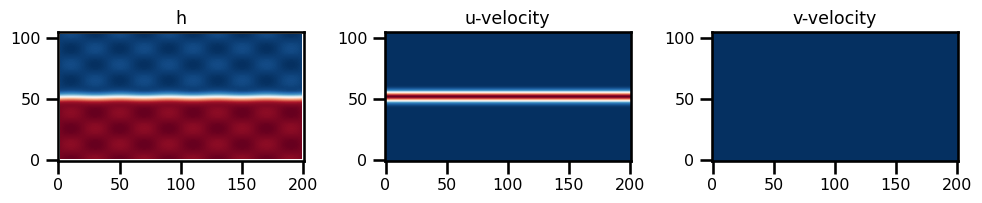

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow(state_init.h.T, origin="lower", cmap="RdBu_r")
ax[0].set(title="h")

ax[1].imshow(state_init.u.T, origin="lower", cmap="RdBu_r")
ax[1].set(title="u-velocity")

ax[2].imshow(state_init.v.T, origin="lower", cmap="RdBu_r")
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()

In [13]:
state_update = ShallowWater2D.equation_of_motion(0, state_init, params)
state_update_adv = ShallowWater2D.equation_of_motion_advection(0, state_init, params)

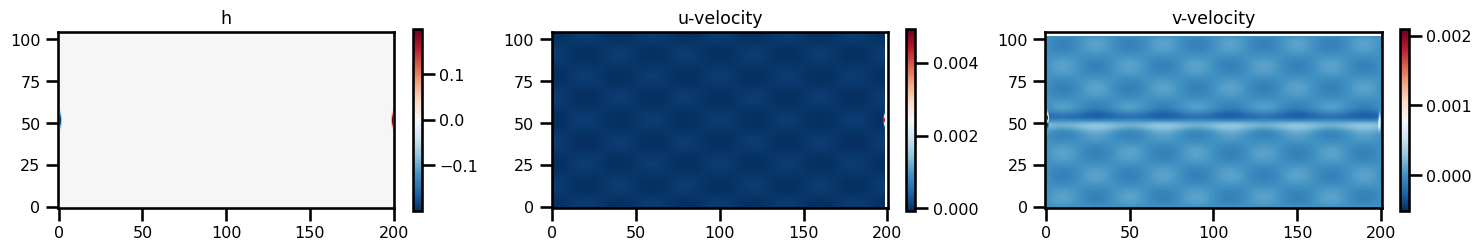

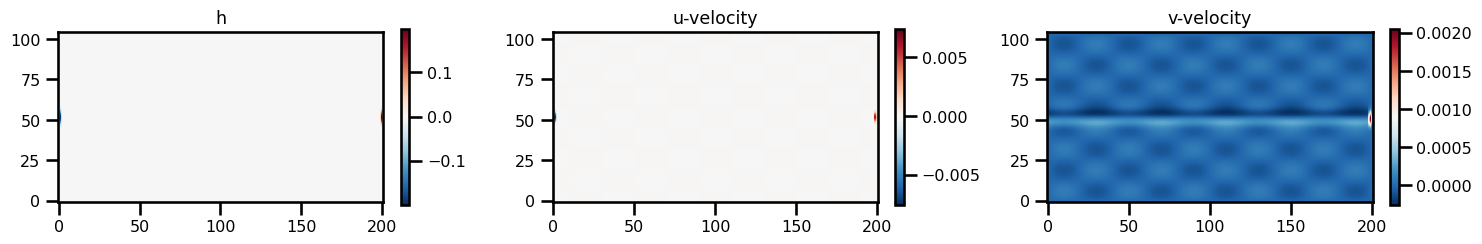

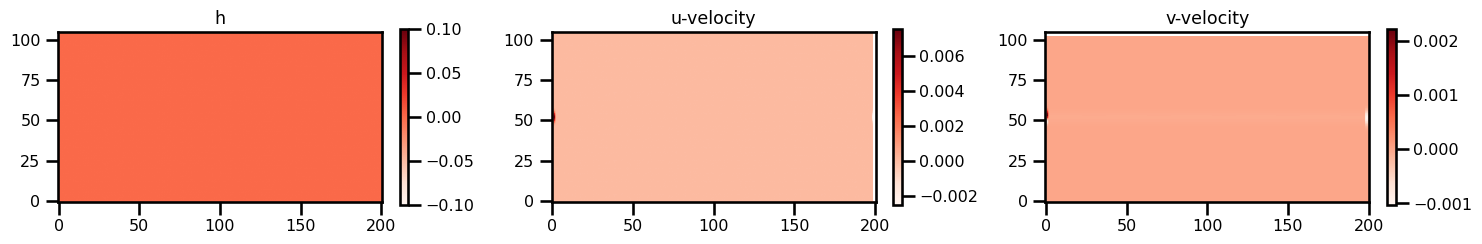

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
pts = ax[0].imshow(state_update.h.T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts, fraction=0.025)
ax[0].set(title="h")

pts = ax[1].imshow(state_update.u.T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts, fraction=0.025)
ax[1].set(title="u-velocity")

pts = ax[2].imshow(state_update.v.T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts, fraction=0.025)
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
pts = ax[0].imshow(state_update_adv.h.T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts, fraction=0.025)
ax[0].set(title="h")

pts = ax[1].imshow(state_update_adv.u.T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts, fraction=0.025)
ax[1].set(title="u-velocity")

pts = ax[2].imshow(state_update_adv.v.T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts, fraction=0.025)
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
pts = ax[0].imshow(state_update.h.T - state_update_adv.h.T, origin="lower", cmap="Reds")
plt.colorbar(pts, fraction=0.025)
ax[0].set(title="h")

pts = ax[1].imshow(state_update.u.T - state_update_adv.u.T, origin="lower", cmap="Reds")
plt.colorbar(pts, fraction=0.025)
ax[1].set(title="u-velocity")

pts = ax[2].imshow(state_update.v.T - state_update_adv.v.T, origin="lower", cmap="Reds")
plt.colorbar(pts, fraction=0.025)
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()

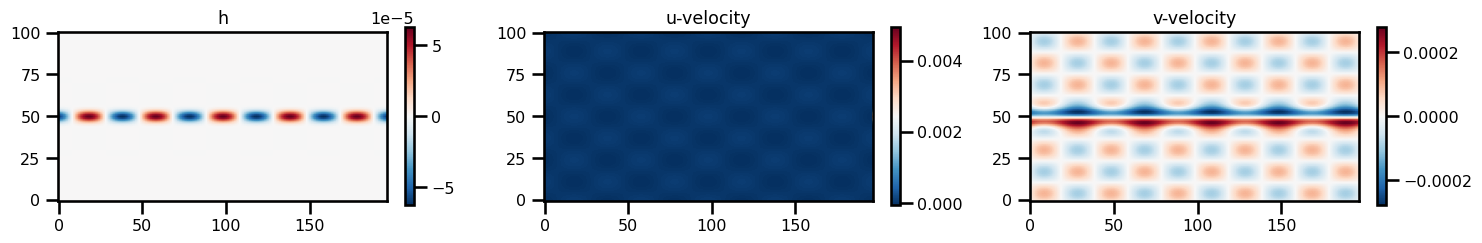

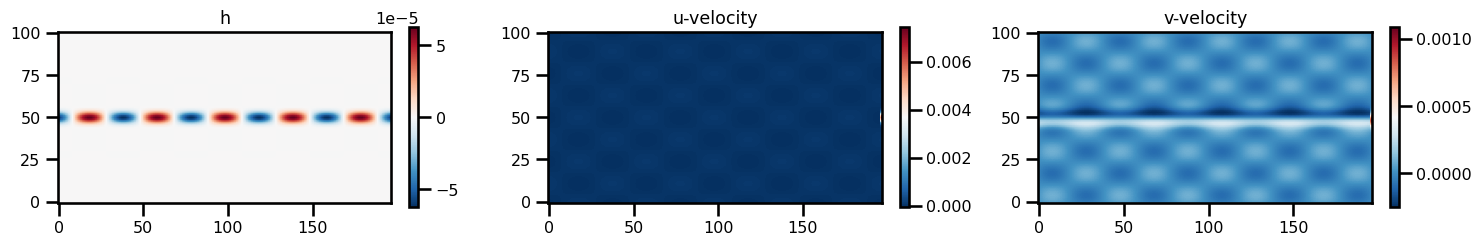

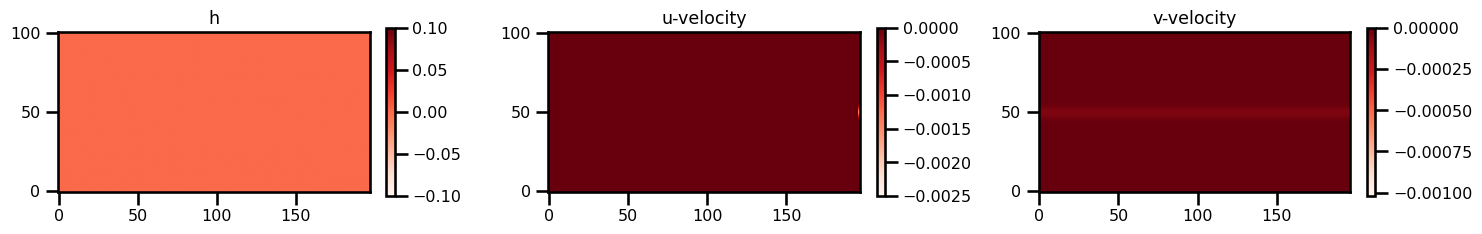

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
pts = ax[0].imshow(state_update.h[2:-2, 2:-2].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts, fraction=0.025)
ax[0].set(title="h")

pts = ax[1].imshow(state_update.u[2:-2, 2:-2].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts, fraction=0.025)
ax[1].set(title="u-velocity")

pts = ax[2].imshow(state_update.v[2:-2, 2:-2].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts, fraction=0.025)
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
pts = ax[0].imshow(state_update_adv.h[2:-2, 2:-2].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts, fraction=0.025)
ax[0].set(title="h")

pts = ax[1].imshow(state_update_adv.u[2:-2, 2:-2].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts, fraction=0.025)
ax[1].set(title="u-velocity")

pts = ax[2].imshow(state_update_adv.v[2:-2, 2:-2].T, origin="lower", cmap="RdBu_r")
plt.colorbar(pts, fraction=0.025)
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
pts = ax[0].imshow(
    state_update.h[2:-2, 2:-2].T - state_update_adv.h[2:-2, 2:-2].T,
    origin="lower",
    cmap="Reds",
)
plt.colorbar(pts, fraction=0.025)
ax[0].set(title="h")

pts = ax[1].imshow(
    state_update.u[2:-2, 2:-2].T - state_update_adv.u[2:-2, 2:-2].T,
    origin="lower",
    cmap="Reds",
)
plt.colorbar(pts, fraction=0.025)
ax[1].set(title="u-velocity")

pts = ax[2].imshow(
    state_update.v[2:-2, 2:-2].T - state_update_adv.v[2:-2, 2:-2].T,
    origin="lower",
    cmap="Reds",
)
plt.colorbar(pts, fraction=0.025)
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()

## Time Stepping

In [16]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain

dt = 0.125 * min(domain.dx[0], domain.dx[1]) / np.asarray(params.phase_speed)
print(f"Step Size (dt): {pd.to_timedelta(dt, unit='second')}")

tmin = 0.0
tmax = pd.to_timedelta(2.0, unit="days").total_seconds()
num_save = 100
print(f"tmin: {pd.to_timedelta(tmin, unit='second')}")
print(f"tmax: {pd.to_timedelta(tmax, unit='second')}")

Step Size (dt): 0 days 00:00:19.954714275
tmin: 0 days 00:00:00
tmax: 2 days 00:00:00


In [17]:
pd.to_timedelta(dt, unit="seconds")

Timedelta('0 days 00:00:19.954714275')

In [18]:
import pandas as pd

In [19]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = ShallowWater2D(t_domain=t_domain, saveat=saveat)

### Integration

In [20]:
# Euler, Constant StepSize
solver = dfx.Dopri5()

# Tolerances
stepsize_controller = dfx.ConstantStepSize()
# rtol = 1e-3
# atol = 1e-3
# stepsize_controller = dfx.PIDController(
#     pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, #dtmax=dt
# )

# SPATIAL DISCRETIZATION
params_init = SWMParams(
    depth=100.0, gravity=9.81, coriolis_f0=2e-4, coriolis_beta=2e-11, domain=domain
)
state_init = SWMState.init_state(params_init, init_h=init_h0, init_u=init_u0)

In [21]:
%%time

# integration
sol = dfx.diffeqsolve(
    # terms=dfx.ODETerm(dyn_model.equation_of_motion_advection),
    terms=dfx.ODETerm(dyn_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params_init,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

CPU times: user 1min 4s, sys: 5.68 s, total: 1min 10s
Wall time: 1min


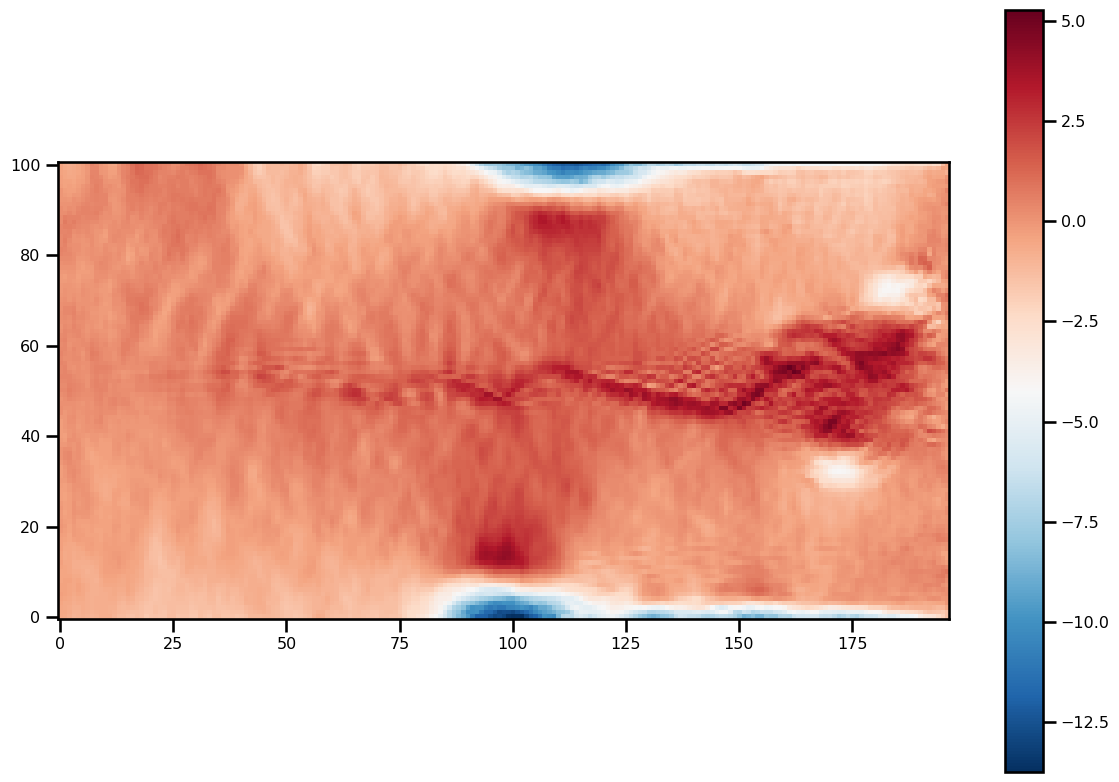

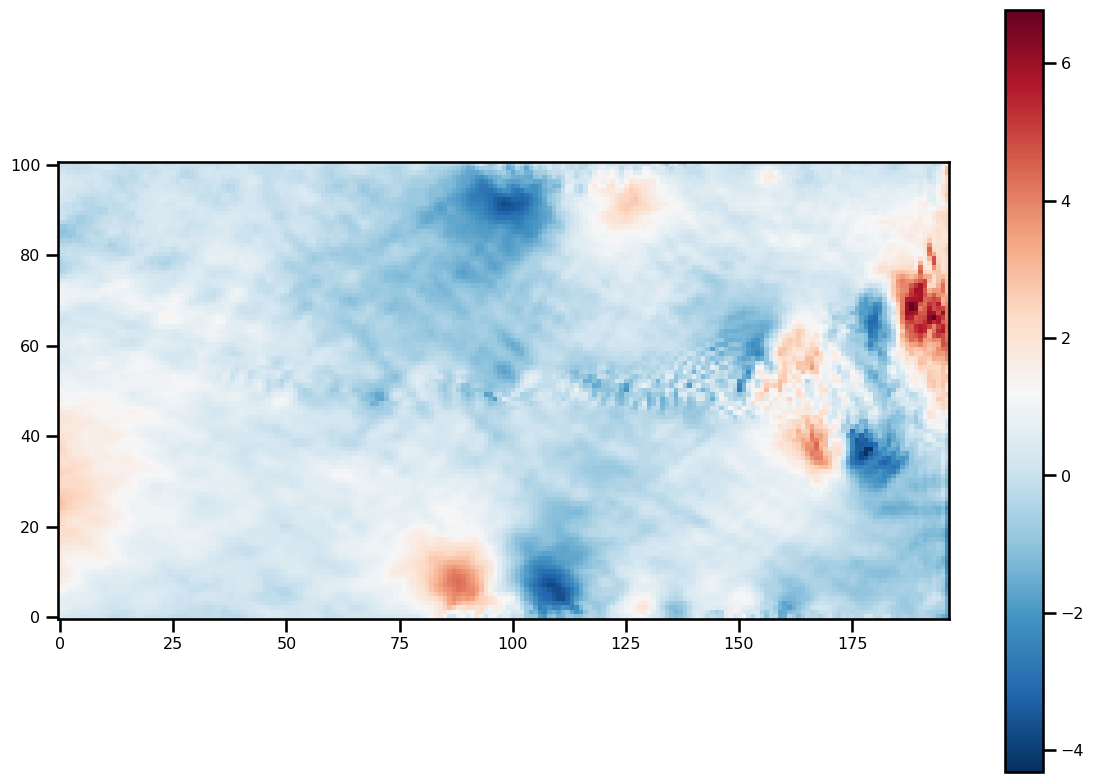

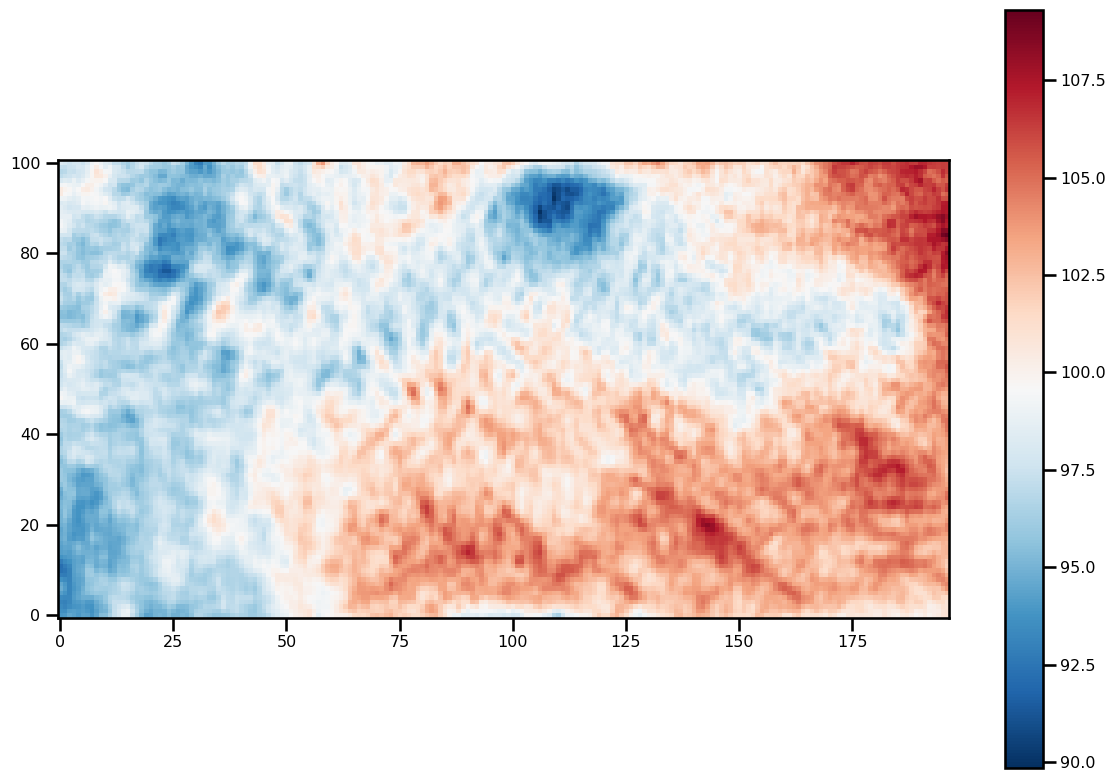

In [22]:
for ivar in sol.ys:
    fig, ax = plt.subplots(figsize=(12, 8))
    pts = ax.imshow(ivar[-1][2:-2, 2:-2].T, origin="lower", cmap="RdBu_r")
    plt.colorbar(pts)
    plt.tight_layout()

## Analysis

In [23]:
ds_results = xr.Dataset(
    data_vars={
        "u": (("time", "x", "y"), sol.ys.u),
        "v": (("time", "x", "y"), sol.ys.v),
        "h": (("time", "x", "y"), sol.ys.h),
    },
    coords={
        "time": (("time"), sol.ts),
        "x": (("x"), domain.coords[0]),
        "y": (("y"), domain.coords[1]),
    },
)
ds_results

<xarray.Dataset>
Dimensions:  (time: 100, x: 201, y: 105)
Coordinates:
  * time     (time) float64 0.0 1.745e+03 3.491e+03 ... 1.711e+05 1.728e+05
  * x        (x) float64 0.0 5e+03 1e+04 1.5e+04 ... 9.9e+05 9.95e+05 1e+06
  * y        (y) float64 0.0 5e+03 1e+04 1.5e+04 ... 5.1e+05 5.15e+05 5.2e+05
Data variables:
    u        (time, x, y) float64 4.02e-73 2.512e-70 ... 2.512e-70 4.02e-73
    v        (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    h        (time, x, y) float64 nan nan nan nan nan ... nan nan nan nan nan

In [24]:
# ds_results.to_netcdf("./sw_nonlinear_jet.nc")

In [25]:
from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_h_ke_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)
    time = sub.v.time.values / 86400

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin_h = kwargs.pop("vmin_h", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).min())
    vmax_h = kwargs.pop("vmax_h", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(12, 4.5)

    ax = fig.subplots(
        ncols=2,
    )

    # HEIGHT
    cbar_kwargs = {"label": "Height [m]"}
    pts = sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[0],
        cmap="viridis",
        add_colorbar=True,
        vmin=vmin_h,
        vmax=vmax_h,
        cbar_kwargs=cbar_kwargs,
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin_h, vmax_h)
    sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.contour(
        ax=ax[0],
        levels=levels,
        vmin=vmin_h,
        vmax=vmax_h,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[0].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # U-VELOCITY
    cbar_kwargs = {"label": "√ Kinetic Energy [ms$^{-2}$]"}
    vmin_ke = kwargs.pop("vmin_ke", sub.ke.isel(x=slice(1, -1), y=slice(1, -1)).min())
    vmax_ke = kwargs.pop("vmax_ke", sub.ke.isel(x=slice(1, -1), y=slice(1, -1)).max())
    pts = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).plot.pcolormesh(
        ax=ax[1],
        cmap="YlGnBu_r",
        add_colorbar=True,
        vmin=vmin_ke,
        vmax=vmax_ke,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin_ke, vmax_ke)
    sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).plot.contour(
        ax=ax[1],
        levels=levels,
        vmin=vmin_ke,
        vmax=vmax_ke,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[1].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    plt.tight_layout()
    return None, None


from pathlib import Path


def create_movie(
    var,
    name,
    plotfunc=custom_plot_h_ke_layers,
    framedim: str = "steps",
    file_path=None,
    **kwargs,
):
    if file_path is not None:
        file_name = Path(file_path).joinpath(f"movie_{name}.gif")
    else:
        file_name = Path(f"./movie_{name}.gif")

    mov = Movie(
        var, plotfunc=plotfunc, framedim=framedim, **kwargs, dpi=200, input_check=False
    )
    mov.save(
        file_name,
        remove_movie=False,
        progress=True,
        framerate=3,
        gif_framerate=3,
        overwrite_existing=True,
        gif_resolution_factor=0.5,
        parallel=False,
    )

    return None

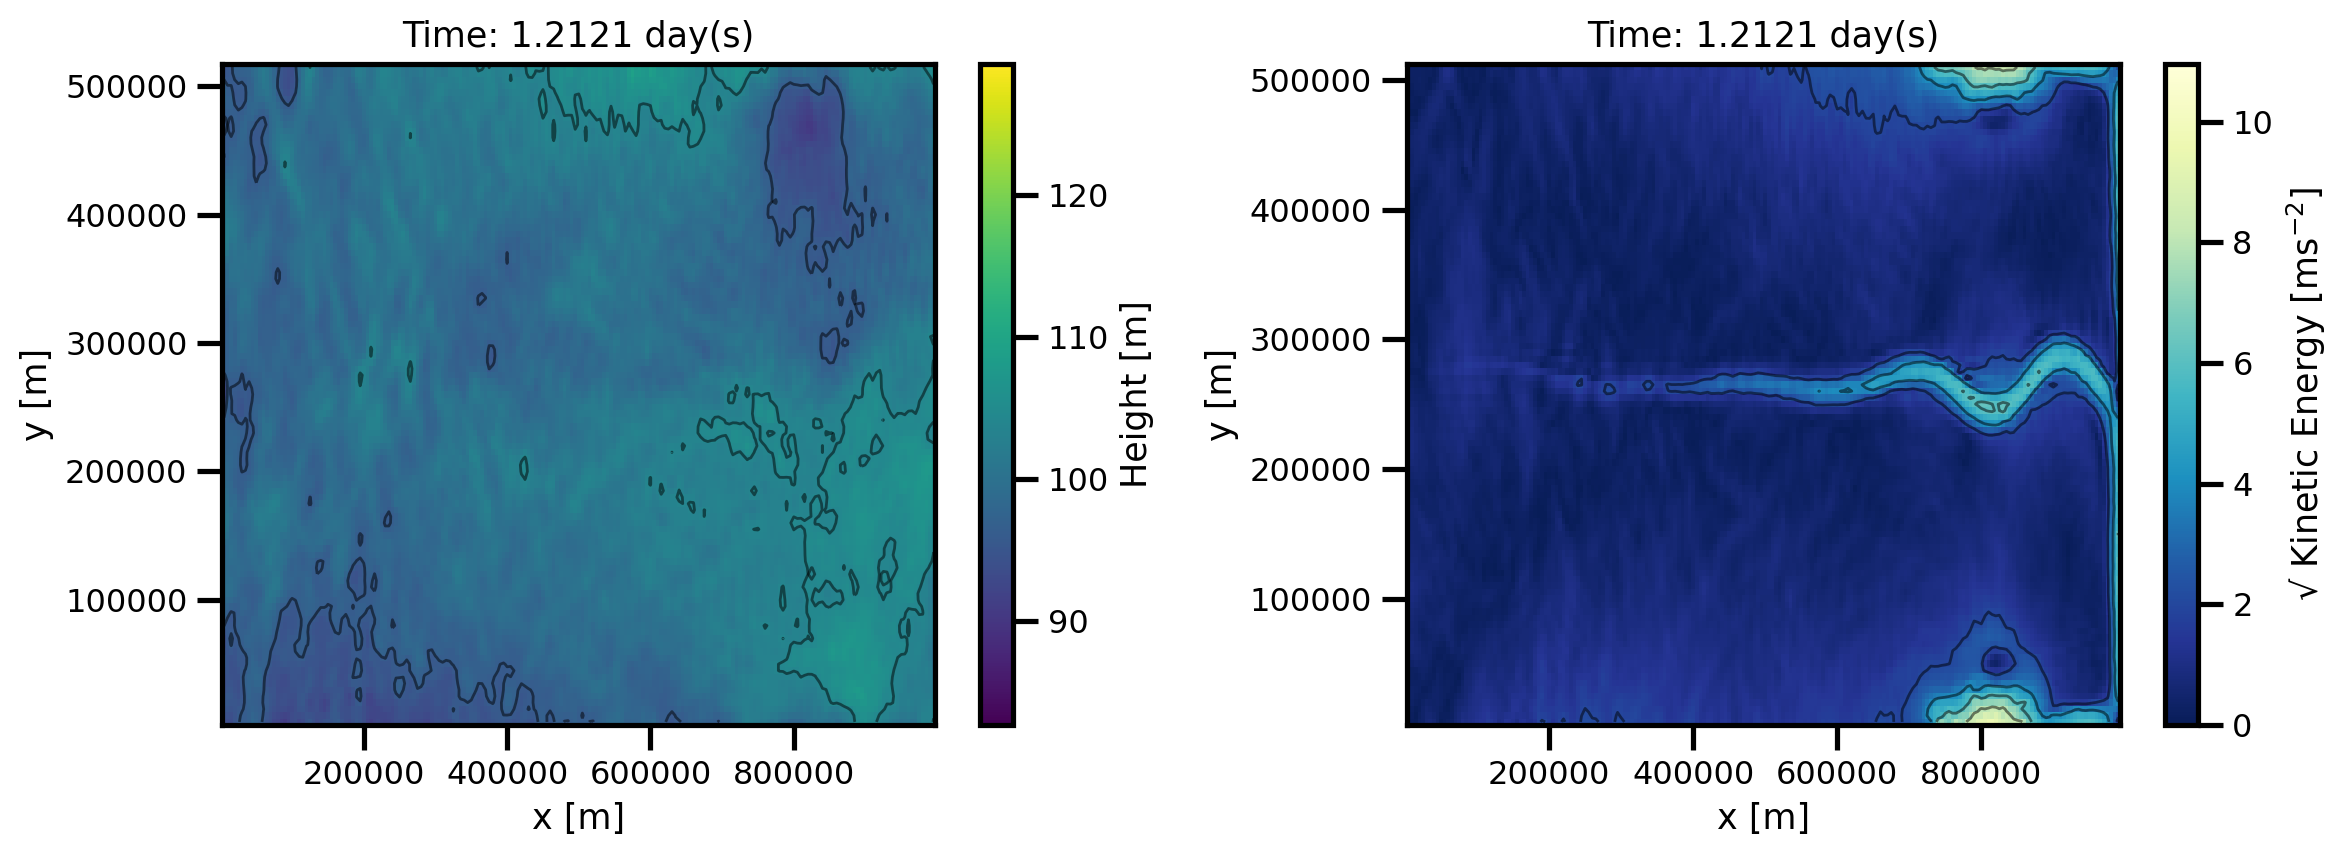

In [26]:
%matplotlib inline
vmin_h = ds_results.h.isel(x=slice(2, -2), y=slice(2, -2)).min()
vmax_h = ds_results.h.isel(x=slice(2, -2), y=slice(2, -2)).max()

ds_results["ke"] = np.sqrt(0.5 * (ds_results.u**2 + ds_results.v**2))

vmin_ke = ds_results.ke.isel(x=slice(2, -2), y=slice(2, -2)).min()
vmax_ke = ds_results.ke.isel(x=slice(2, -2), y=slice(2, -2)).max()

mov = Movie(
    ds_results.transpose("time", "y", "x"),
    plotfunc=custom_plot_h_ke_layers,
    framedim="time",
    input_check=False,
    vmin_h=vmin_h,
    vmax_h=vmax_h,
    vmin_ke=vmin_ke,
    vmax_ke=vmax_ke,
)
mov.preview(60)

In [27]:
create_movie(
    ds_results.transpose(
        "time", "y", "x"
    ),  # .sel(time=slice("2017-02-01", "2017-03-01")),
    # name="swe_nonlinear_jet_adv_linear",
    name="swe_nonlinear_jet_vort_upwind",
    plotfunc=custom_plot_h_ke_layers,
    file_path="./",
    framedim="time",
    cmap="viridis",
    robust=True,
    vmin_h=vmin_h,
    vmax_h=vmax_h,
    vmin_ke=vmin_ke,
    vmax_ke=vmax_ke,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Movie created at movie_swe_nonlinear_jet_vort_upwind.mp4
GIF created at movie_swe_nonlinear_jet_vort_upwind.gif
